# HOMEWORK 3: Designing Closed Loop Systems

**COMMENTS**

I re-graded Q2. You created a closed loop system that stablizes within 10s, but it's biased: it converges to 5, not 1.

This homework involves designing a closed loop system with a PID controller.

In [ ]:
!pip -q install controlSBML
import controlSBML as ctl
import control
from controlSBML.util import makeSimulationTimes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import tellurium as te
import sympy
print("controlSBML version: " + ctl.__version__)

     |████████████████████████████████| 398 kB 13.5 MB/s 
     |████████████████████████████████| 8.8 MB 28.2 MB/s 
     |████████████████████████████████| 154 kB 47.2 MB/s 
     |████████████████████████████████| 438 kB 46.9 MB/s 
     |████████████████████████████████| 6.8 MB 37.9 MB/s 
     |████████████████████████████████| 121 kB 44.7 MB/s 
     |████████████████████████████████| 428 kB 42.2 MB/s 
     |████████████████████████████████| 54 kB 1.5 MB/s 
     |████████████████████████████████| 342 kB 40.1 MB/s 
     |████████████████████████████████| 561 kB 49.3 MB/s 
     |████████████████████████████████| 130 kB 43.1 MB/s 
     |████████████████████████████████| 80 kB 10.6 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 133 kB 56.0 MB/s 
     |████████████████████████████████| 103 kB 54.4 MB/s 
     |████████████████████████████████| 250 kB 52.5 MB/s 
     |████████████████████████████████| 843 kB 47.8 MB/s 
     |█████████████

In [ ]:
# Use the local file if it's available
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

In this homework, you will design a closed loop system for controlling pDEPTOR in the mTOR system as modelled in BioModels 823.
Use pAkt as the control input.
1. **Build**. (4 pt) Implement the function ``evaluateDesign`` that evaluates the control design of
a closed loop system for mTOR.
The evaluation is in the form of a plot of the step response of the system
to a change in the reference input.
The plot should include the reference input along with the pAkt and pDEPTO
values for the closed loop mTOR system. The function has as inputs the design parameters kp, ki, kd.
1. **Design**. (2 pt) Use ``evaluateDesign`` to design a system that has no bias for a unit step response in the reference and settles within 10 seconds.
1. **Analysis**. (3 pt) Construct the transfer function
for mTOR from pAkt to pDEPTOR
and the transfer function $H_{NY} (s)$ for the design parameters you used in (2)
(Obtain the Jacobian at time 1 from the open loop mTOR system.)
Use these transfer functions to answer the following questions about how the closed loop system should behave *in theory*.
   1. Why are large control inputs required to control the mTOR system?
   1. Why are there no long term oscillations in the closed loop system?
   1. How will a step increase in noise affect the output of the closed loop system?
1. **Discussion**. (1 pt) Plot the values of pAkt for the closed loop system you designed in (2).
What issues do you see with using this closed loop system in practice?

# Q1. Build

### Viewing the system

In [ ]:
TIMES = ctl.makeSimulationTimes(0, 5, 50)
# Constants
REF = 10

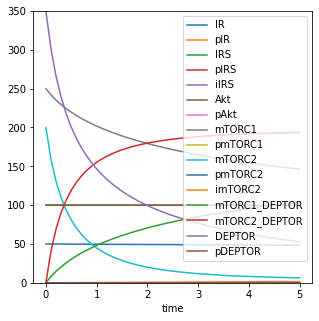

In [ ]:
# See Raw model
ctlsb = ctl.ControlSBML(BIOMD823)
ctlsb.plotTrueModel(figsize=(5,5))

### Helper Funtions

In [ ]:
def plotTFs(Gs, kp=0, ki=0, kd=0, times=TIMES, ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    kp: float
    ki: float
    kd: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
    Fs = 1
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=times, U=1)
        plt.plot(result.t.flatten(), result.y.flatten())
    # Refine plots
    plt.legend(list(tf_dct.keys()))
    xmax = max(result.t.flatten())
    plt.plot([0, xmax], [0, 0], linestyle="--", color="black")
    plt.plot([0, xmax], [1, 1], linestyle="--", color="grey")
    plt.ylim([-5, 5])
    title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
    plt.title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, kp=10, ylim=[0, 3], title="Example", is_plot=False)
assert(len(dct) == 4)
assert("TransferFunction" in str(type(dct["HRYs"])))
print("OK!")

OK!


In [ ]:
def makeHRY(model, input_name, output_name, time=0, kp=0, ki=0, kd=0):
    """
    Calculates the transfer function from the reference input to the output.
    
    Parameters
    ----------
    model: str
    input_name: str
    output_name: str
    time: float
    kp: float
    ki: float
    kd: float
    
    Returns
    -------
    control.TransferFunction
    """
    ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=[output_name])
    Gs = ctlsb.makeTransferFunction(time=time)
    dct = plotTFs(Gs, kp=kp, ki=ki, kd=kd, is_plot=False)
    return dct["HRYs"]
    
    
# TESTS
tf = makeHRY(BIOMD823, "DEPTOR", "pDEPTOR", kp=0)
assert(tf.dcgain() == 0)
print("OK!")

OK!


### Primary Function: evaluateDesign 

In [ ]:
def evaluateDesign(model=BIOMD823, input_name="pAkt", output_name="pDEPTOR", kp=0, ki=0, kd=0,
               is_plot=True):
    """
    Run the testbed and plot the results.
    
    Parameters
    ---------
    model: str
        System under control
    input_name: str
    output_name: str
    kp: float
    ki: float
    kd: float
    is_plot: bool
    
    Results
    -------
    control.InterconnectedSystem
    plot

    """
    # Construct elements of the closed loop system
    factory = ctl.IOSystemFactory()
    
    # Create the elements of the feedback loop
    ctlsb = ctl.ControlSBML(BIOMD823, input_names=[input_name], output_names=[output_name])
    system = ctlsb.makeNonlinearIOSystem("system")
    controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd)
    sum_R_F = factory.makeAdder("sum_R_F")

    # Construct the Interconnected system
    system_in = "system.%s" % input_name
    system_out = "system.%s" % output_name

    closed_loop = control.interconnect(
      [system, controller, sum_R_F ], 
      connections=[
        ['controller.in', 'sum_R_F.out'],    # e(t)
        [system_in,   'controller.out'],
        ['sum_R_F.in1', "-" + system_out ],        # y(t)

      ],
      inplist=["sum_R_F.in2"],
      outlist=["sum_R_F.in2", system_in, system_out],
      )

    # Do the simulation and plot
    X0 = ctl.makeStateVector(closed_loop)

    times = ctl.makeSimulationTimes(start_time=0, end_time=15, points_per_time=10)
    # Need the initial state

    result = control.input_output_response(closed_loop, T=times, U=5, X0=X0)
    plt.plot(result.t, result.outputs[0].flatten())
    plt.plot(result.t, result.outputs[1].flatten())
    plt.plot(result.t, result.outputs[2].flatten())

    plt.ylim([-1, 20])
    legends = ["Reference input ", "pAkt Values", "pDEPTOR Values"]
    plt.legend(legends)
    if not is_plot:
        plt.close()
    #
    return closed_loop, factory

# Tests
interconnect_sys, _ = evaluateDesign(is_plot=False)
assert("Interconnect" in str(type(interconnect_sys)))
print("OK!")

OK!


,sum_R_F.in1,sum_R_F.in2,sum_R_F.out,controller.in,controller.last_err,controller.acc_err,controller.out
time,,,,,,,
0.000000,0.000000e+00,5.0,5.000000,5.000000,0.000000,0.000000,5000.000000
0.000001,-7.831090e-11,5.0,5.000000,5.000000,0.000052,0.000052,5000.000000
0.000002,-5.568701e-10,5.0,5.000000,5.000000,0.000139,0.000139,4999.999999
0.000003,-8.701122e-10,5.0,5.000000,5.000000,0.000173,0.000173,4999.999999
0.000010,-4.350541e-09,5.0,5.000000,5.000000,0.000520,0.000520,4999.999996
...,...,...,...,...,...,...,...
14.974015,-4.385574e+00,5.0,0.614426,0.614426,0.620098,16.312307,614.426293
14.977263,-4.386134e+00,5.0,0.613866,0.613866,0.619886,16.332223,613.865762
14.993503,-4.388995e+00,5.0,0.611005,0.611005,0.618764,16.431657,611.005147


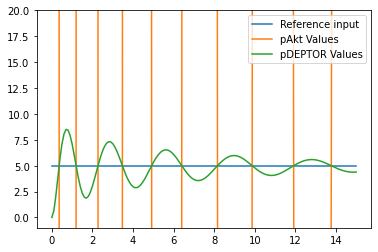

In [ ]:
_,factory = evaluateDesign(kp=1000,ki=0,kd=0)
factory.report()

/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1632: BadCoefficients:

Badly conditioned filter coefficients (numerator): the results may be meaningless

/usr/local/lib/python3.7/dist-packages/scipy/signal/filter_design.py:1632: BadCoefficients:

Badly conditioned filter coefficients (numerator): the results may be meaningless



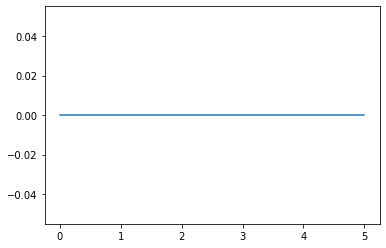

In [ ]:
Gs_BIOMD823 = makeHRY(BIOMD823, "pAkt", "pDEPTOR",  time=1, kp=1, ki=0, kd=0)
BIOMD823_stepmodel = control.forced_response(Gs_BIOMD823,T=TIMES)
plt.plot(BIOMD823_stepmodel.t.flatten(),BIOMD823_stepmodel.outputs.flatten())

# Q2. Design

(<InterconnectedSystem:sys[73]:['u[0]']->['y[0]', 'y[1]', 'y[2]']>,
 <controlSBML.iosystem_factory.IOSystemFactory at 0x7f8ba69fad50>)

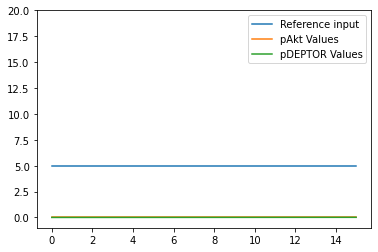

In [ ]:
evaluateDesign()

This is the only parametes that works with makeHRY to make a tf

(<InterconnectedSystem:sys[74]:['u[0]']->['y[0]', 'y[1]', 'y[2]']>,
 <controlSBML.iosystem_factory.IOSystemFactory at 0x7f8ba6a22c10>)

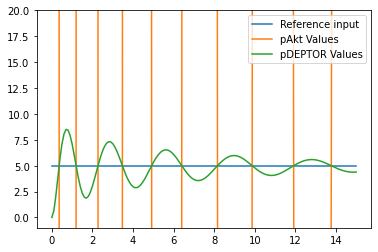

In [ ]:
evaluateDesign(BIOMD823, input_name="pAkt", output_name="pDEPTOR", kp=1000, ki=0, kd=0)

These are the parameters i'd like to select for my system

(<InterconnectedSystem:sys[75]:['u[0]']->['y[0]', 'y[1]', 'y[2]']>,
 <controlSBML.iosystem_factory.IOSystemFactory at 0x7f8ba3b58e10>)

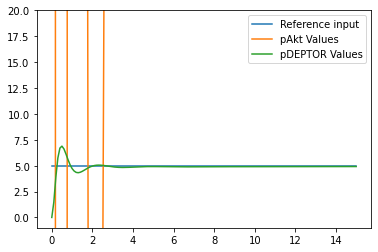

In [ ]:
evaluateDesign(BIOMD823, input_name="pAkt", output_name="pDEPTOR", kp=1000, ki=0, kd=200)

# Q3. Analyze

### Part 1

TF can't be contstucted with other parameters for ki and kd. So kp = 1000, i will have to accepte the osilation

In [ ]:
Gs_BIOMD823 = makeHRY(BIOMD823, "pAkt", "pDEPTOR",  time=1, kp=1000, ki=0, kd=0)
Gs_BIOMD823

TransferFunction(array([-8.88178420e-012,  2.89351852e+001,  4.77394308e+002,
        2.94616749e+003,  8.57841210e+003,  1.26199432e+004,
        1.03580168e+004,  4.98025853e+003,  1.40437964e+003,
        2.22617142e+002,  1.85649050e+001,  8.72075691e-001,
        2.40993321e-002,  3.89802214e-004,  3.42115023e-006,
        1.26001512e-008,  2.16596209e-022,  1.66064495e-038,
       -1.53432180e-054, -3.43980909e-073,  8.38306090e-089,
       -2.87936072e-105,  5.98163681e-124, -7.43297205e-140,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000]), array([ 1.00000000e+000,  2.30701720e+001,  2.42603579e+002,
        1.49953083e+003,  5.67963788e+003,  1.28189484e+004,
        1.66398081e+004,  1.27649464e+004,  5.89701622e+003,
        1.62198632e+003,  2.53241734e+002,  2.09635743e+001,
        9.80895753e-001,  2.70435401e-002,  4.36767813e-004,
        3.82938855e-006,  1.40931601e-008,  2.16829493e-022,
     

In [ ]:
print("The DC gain of the system is", Gs_BIOMD823.dcgain(), " and the poles are ", Gs_BIOMD823.pole())

The DC gain of the system is nan  and the poles are  [-3.28571236e+00+4.64411980e+00j -3.28571236e+00-4.64411980e+00j
 -5.99999615e+00+0.00000000e+00j -3.96034302e+00+0.00000000e+00j
 -3.96034170e+00+0.00000000e+00j -5.71428571e-01+0.00000000e+00j
 -5.01657639e-01+1.46395901e-06j -5.01657639e-01-1.46395901e-06j
 -4.28571428e-01+9.12170172e-07j -4.28571428e-01-9.12170172e-07j
 -3.30898952e-02+0.00000000e+00j -3.30898227e-02+0.00000000e+00j
 -2.00181061e-02+0.00000000e+00j -1.99999807e-02+1.80867673e-05j
 -1.99999807e-02-1.80867673e-05j -1.99819324e-02+0.00000000e+00j
 -1.53080565e-14+0.00000000e+00j -1.31311647e-16+0.00000000e+00j
  5.39998459e-17+0.00000000e+00j -1.37881623e-17+0.00000000e+00j
  7.26416506e-18+1.20070512e-21j  7.26416506e-18-1.20070512e-21j
 -4.07353318e-19+0.00000000e+00j -4.06165328e-19+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.0

In [ ]:
kp = 1000
ki = 0
kd = 0
Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
Fs = 1
denom = 1 + Cs*Gs*Fs
HNYs = -Fs/denom
print("The DC gain of noise is", int(HNYs.dcgain()), " and the poles are ", HNYs.pole())
print("The transfer function of noise is", HNYs)

The DC gain of noise is 0  and the poles are  [-2003.+0.j]
The transfer function of noise is 
 -s - 3
--------
s + 2003



##### Plot Transfer functions

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=1.02209e-17): result may not be accurate.



{'HDYs': TransferFunction(array([ 1.00000000e+003,  2.30701720e+004,  2.42603579e+005,
         1.49953083e+006,  5.67963788e+006,  1.28189484e+007,
         1.66398081e+007,  1.27649464e+007,  5.89701622e+006,
         1.62198632e+006,  2.53241734e+005,  2.09635743e+004,
         9.80895753e+002,  2.70435401e+001,  4.36767813e-001,
         3.82938855e-003,  1.40931601e-005,  2.16829493e-019,
         1.65946509e-035, -1.53596699e-051, -2.72183055e-070,
         8.38699605e-086, -2.87565414e-102,  6.00187916e-121,
        -7.42833701e-137,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000]), array([ 1.00000000e+000,  2.30701720e+001,  2.91777888e+004,
         4.78893839e+005,  2.95184713e+006,  8.59123105e+006,
         1.26365830e+007,  1.03707818e+007,  4.98615555e+006,
         1.40600163e+006,  2.22870384e+005,  1.85858686e+004,
         8.73056587e+002,  2.41263756e+001,  3.90238981e-001,
         3.4249796

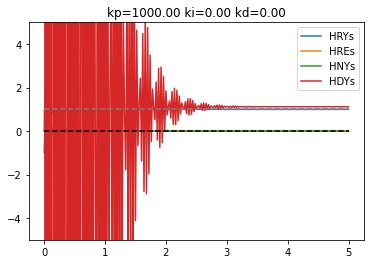

In [ ]:
plotTFs(Gs_BIOMD823, kp=1000, ki=0, kd=0, times=TIMES, ylim=None, title=None, is_plot=True)

Text(0.5, 1.0, 'Noise transfer funtion plot')

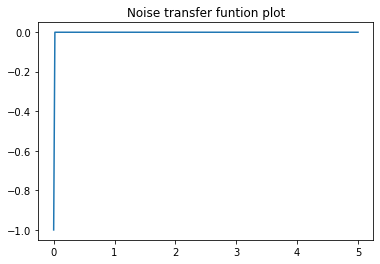

In [ ]:
result = control.forced_response(HNYs, T=TIMES, U=1)
plt.plot(result.t.flatten(), result.y.flatten())
plt.title("Noise transfer funtion plot")

##### Plots  of the transfer function at the kp = 1000 and the alteration of the control values  (Seems that kd changes make the system unstable)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=5.36057e-17): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=5.36057e-17): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=5.36057e-17): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=6.1648e-17): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=6.1648e-17): result may not be accurate.

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/matfuncs.py:709: LinAlgWarning:

Ill-conditioned matrix (rcond=6.1648e-17): result may not be accurate.

/usr/local/li

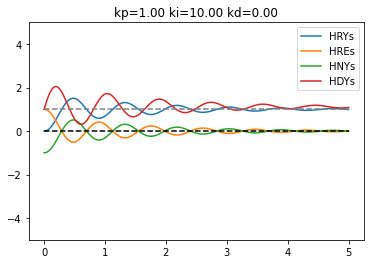

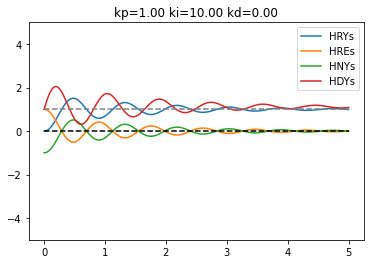

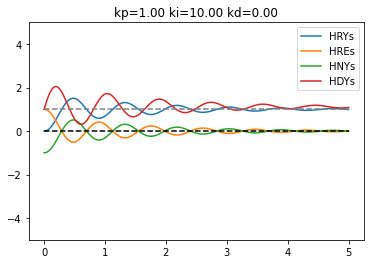

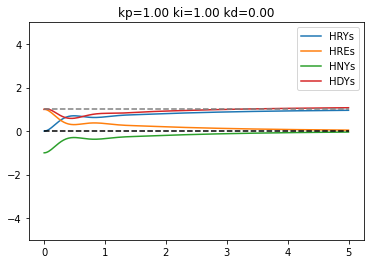

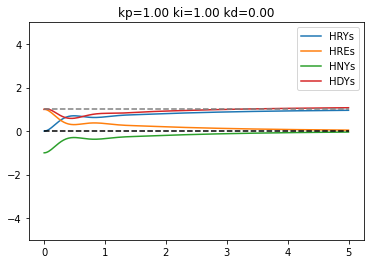

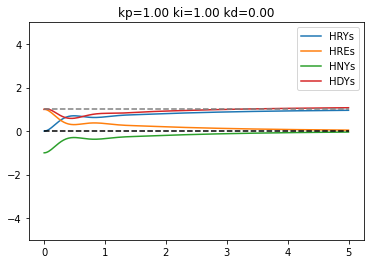

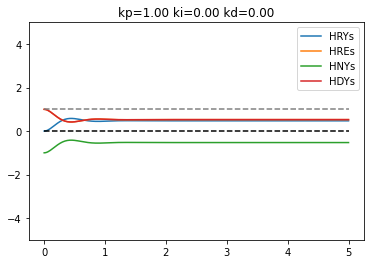

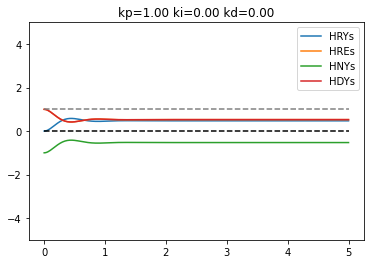

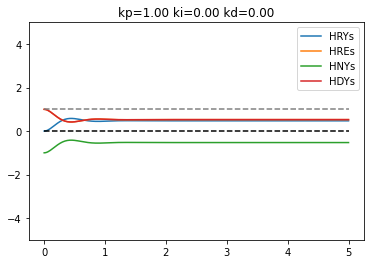

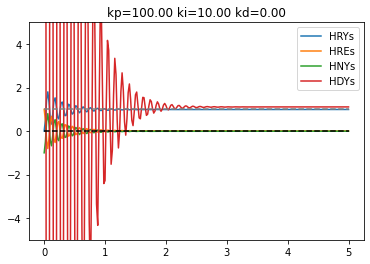

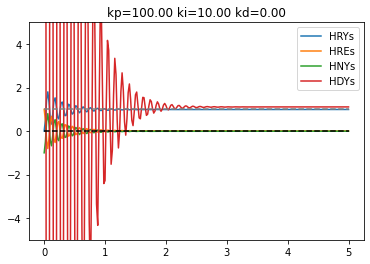

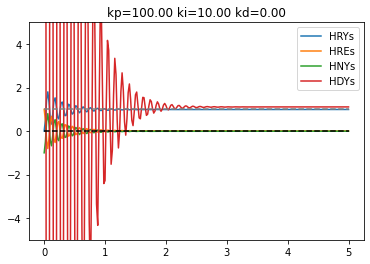

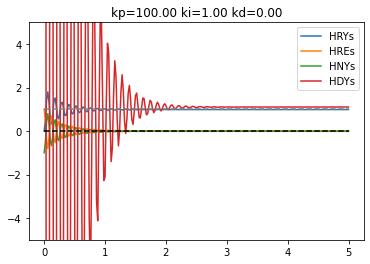

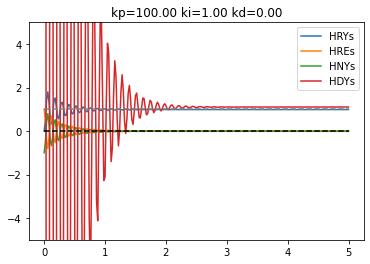

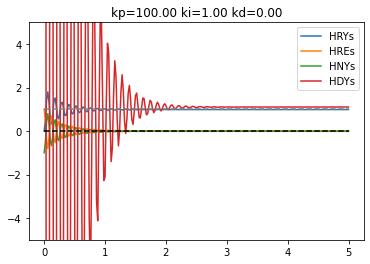

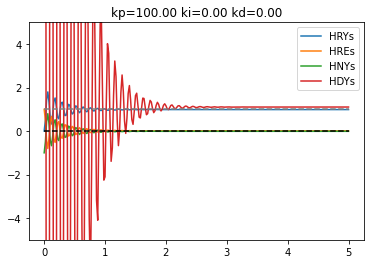

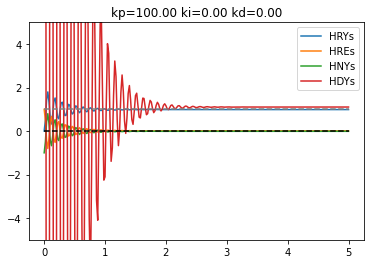

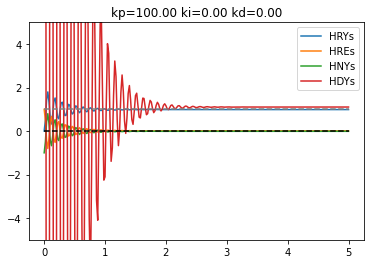

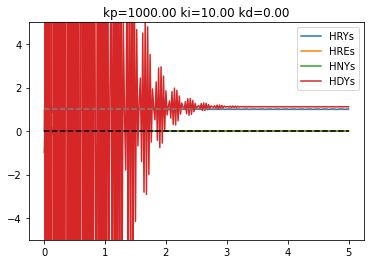

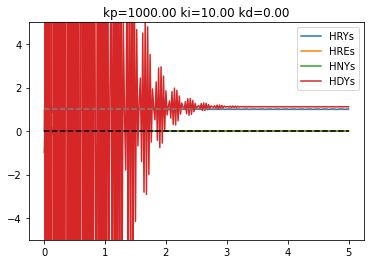

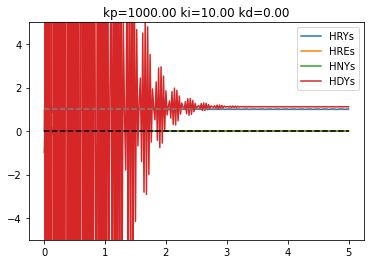

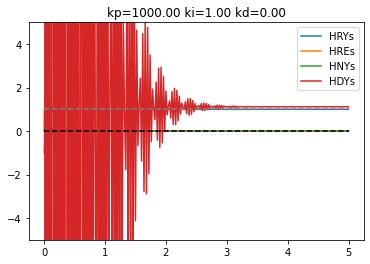

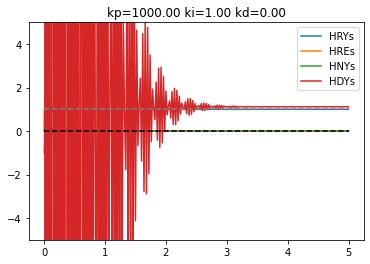

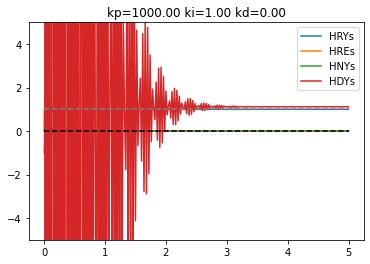

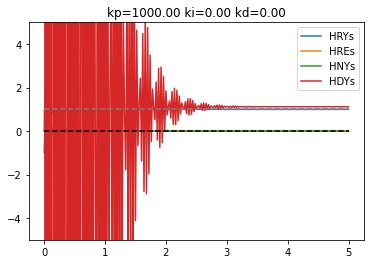

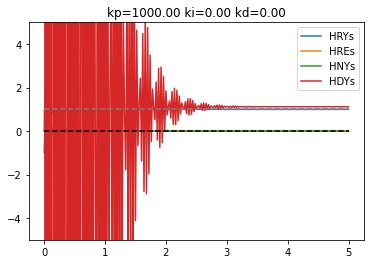

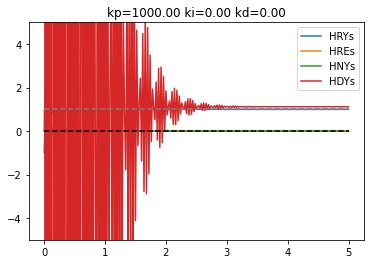

In [ ]:
for kp in [1, 100, 1000]:
    for ki in [10, 1, 0]:
      for kd in [0, 0, 0]:
          title = "kp: %2.1f ki: %2.1f ld: %2.1f" % (kp, ki, kd)
          _ = plotTFs(Gs_BIOMD823, kp=kp, ki=ki, kd=kd, title=title, ylim=[-1, 30])

### Part 2

#### Jacobian

In [ ]:
OP_TIME =  1
BIOMD823_JACOBIAN = ctlsb.getJacobian(OP_TIME)
BIOMD823_JACOBIAN

,IR,pIR,IRS,pIRS,iIRS,Akt,pAkt,mTORC1,pmTORC1,mTORC2,pmTORC2,imTORC2,mTORC1_DEPTOR,mTORC2_DEPTOR,DEPTOR,pDEPTOR
IR,-0.004518,0.028571,0.0,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.000,0.000,0.00,0.000000
pIR,0.004518,-0.028571,0.0,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.000,0.000,0.00,0.000000
IRS,0.000000,-0.066667,0.0,0.020000,0.02,0.0,0.000000,0.00,-0.066667,0.00,0.000000,0.0,0.000,0.000,0.00,0.000000
pIRS,0.000000,0.066667,0.0,-0.020000,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.0,0.000,0.000,0.00,0.000000
iIRS,0.000000,0.000000,0.0,0.000000,-0.02,0.0,0.000000,0.00,0.066667,0.00,0.000000,0.0,0.000,0.000,0.00,0.000000
Akt,0.000000,0.000000,0.0,-0.046729,0.00,0.0,0.058824,0.00,0.000000,0.00,-1.442308,0.0,0.000,0.000,0.00,0.000000
pAkt,0.000000,0.000000,0.0,0.046729,0.00,0.0,-0.058824,0.00,0.000000,0.00,1.442308,0.0,0.000,0.000,0.00,0.000000
mTORC1,0.000000,0.000000,0.0,0.000000,0.00,0.0,-0.099206,-0.35,5.999996,0.00,0.000000,0.0,0.006,0.000,-0.25,0.000000
pmTORC1,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.099206,0.00,-5.999996,0.00,0.000000,0.0,0.000,0.000,0.00,0.000000
mTORC2,0.000000,-0.166667,0.0,0.000000,0.00,0.0,0.000000,0.00,0.000000,-2.45,0.428571,0.0,0.000,0.006,-1.40,0.000000


#### (1) Large control inputs are required because the mTOR system has other reactions that keep the system at certain levels and basically resistant to pertabations 

#### (2) They are no long term osilations because the poles of the system are quite small

#### (3) The DC gain of noise is 0 therefore it would have no effect on the input

# Q4. Discussion

Text(0.5, 1.0, 'Values of pAkt')

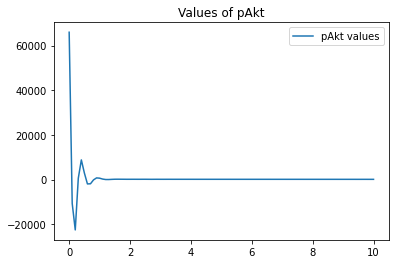

In [ ]:
pAkt_values, _ = evaluateDesign(BIOMD823, input_name="pAkt", output_name="pDEPTOR", kp=1000, ki=0, kd=1000, is_plot=False)
X0 = ctl.makeStateVector(pAkt_values)
times = ctl.makeSimulationTimes(start_time=0, end_time=10, points_per_time=10)
result = control.input_output_response(pAkt_values, T=times, U=6, X0=X0)
plt.plot(result.t, result.outputs[1].flatten())
legends = ["pAkt values"]
plt.legend(legends)
plt.title("Values of pAkt")

#### The primary issuse I see is having to have high values to change the system  while trying to minimize to complexity that the funtions must solve to yeild the output values. At the same time increasing Kp will add osilations to our system.